In [266]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [215]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [216]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [217]:
images, filenames, labels, path, distribusi = insertGambar("dataset/dataset/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne vulgaris


100%|██████████| 100/100 [00:01<00:00, 53.24it/s]


Rosacea


100%|██████████| 100/100 [00:01<00:00, 51.57it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne vulgaris': 100, 'Rosacea': 100}


In [218]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [219]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [220]:
def median(img):
    height, width = img.shape
    kernel = np.zeros((3, 3), np.float32) / 9
    hasilMedian = np.zeros((height, width), dtype=np.uint8)
    for i in range(kernel.shape[0]//2, height-kernel.shape[0]//2):
        for j in range(kernel.shape[0]//2, width-kernel.shape[0]//2):
            temp = []
            for k in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                for l in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                    temp.append(img[i+k][j+l])
            temp.sort()
            median = temp[kernel.shape[0]**2//2]
            if kernel.shape[0]**2 % 2 == 0:
                median = (temp[kernel.shape[0]**2//2 - 1] + temp[kernel.shape[0]**2//2]) // 2
            else:
                median = temp[kernel.shape[0]**2//2]
            hasilMedian[i][j] = median

    return hasilMedian

In [221]:
def getPad(image, kernel):
    i = (kernel.shape[1]-1)//2
    j = (kernel.shape[0]-1)//2

    kiri = i
    kanan = (kernel.shape[1]-1)-i
    atas = j
    bawah = (kernel.shape[0]-1)-j
    result = np.pad(image,((atas, bawah), (kiri,kanan)), 'edge')

    return result

prewittX = np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
])

prewittY = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1]
])

def findEdge(image, kernelx, kernely):
    result = np.zeros(image.shape, dtype=float)
    pad = getPad(image, kernelx)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x = 0
            y = 0
            for k in range(kernelx.shape[0]):
                for l in range(kernelx.shape[1]):
                    x += pad[i+k][j+l] * kernelx[k,l]
                    y += pad[i+k][j+l] * kernely[k,l]
            result[i,j] = np.sqrt(x*x + y*y)
    return result

def prewittFilterData(img):
    gambar = findEdge(img, prewittX, prewittY)
    return gambar

In [222]:
def threshold(gambar):
    ambang = 10
    hasilThreshold = np.where(gambar >= ambang, 128, 255)
    return hasilThreshold

In [223]:
kernel = np.array([[0, 0, 1, 1, 1],
                   [0, 0, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 0, 0],
                   [1, 1, 1, 0, 0]])

def dilasi(citra, mask):
    tinggiPad, lebarPad = mask.shape[0] // 2, mask.shape[1] // 2
    citraPad = np.pad(citra, ((tinggiPad, tinggiPad), (lebarPad, lebarPad)), mode='constant', constant_values=0)
    output = np.zeros(citra.shape, dtype=np.uint8)

    for baris in range(tinggiPad, citraPad.shape[0] - tinggiPad):
        for kolom in range(lebarPad, citraPad.shape[1] - lebarPad):
            area = citraPad[baris - tinggiPad:baris + tinggiPad + 1, kolom - lebarPad:kolom + lebarPad + 1]
            if np.any(area[mask == 1] == 255):
                output[baris - tinggiPad, kolom - lebarPad] = 255

    return output

def erosi(citra, mask):
    padT, padL = mask.shape[0] // 2, mask.shape[1] // 2
    citraPad = np.pad(citra, ((padT, padT), (padL, padL)), mode='constant', constant_values=255)
    hasil = np.zeros_like(citra, dtype=np.uint8)

    for r in range(padT, citraPad.shape[0] - padT):
        for c in range(padL, citraPad.shape[1] - padL):
            blok = citraPad[r - padT:r + padT + 1, c - padL:c + padL + 1]
            if np.all(blok[mask == 1] == 255):
                hasil[r - padT, c - padL] = 255

    return hasil

def opening(citra, mask):
    erosiHasil = erosi(citra, mask)
    openingHasil = dilasi(erosiHasil, mask)
    return openingHasil

In [224]:
def normalize_image(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [225]:
dataPreprocessed = []
for i in range(len(images)): 
    resize_img = resize_image(images[i])
    gray_img = gray_scaling(resize_img)
    medianData = median(gray_img)
    prewittData = prewittFilterData(medianData)
    thresholdData = threshold(prewittData)
    openingData = opening(thresholdData, kernel)
    normalizeData = normalize_image(openingData)
    
    dataPreprocessed.append(normalizeData)

<h1>Feature Extraction</h1>

In [226]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [227]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [228]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [229]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [230]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [231]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [232]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [233]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [234]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [235]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [248]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [236]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [237]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [238]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [239]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [240]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [241]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [244]:
print("Min:", np.min(dataPreprocessed[i]), "Max:", np.max(dataPreprocessed[i]))

Min: 0 Max: 255


In [249]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


<h1>CSV</h1>

In [250]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,10_1.jpg,Acne vulgaris,6823.242188,10090.0,5968.593750,8862.0,0.895069,0.844831,0.908212,0.863716,...,0.458574,0.425703,0.669340,0.642123,0.677181,0.652460,0.770920,0.660148,0.799614,0.701510
1,10_2.jpg,Acne vulgaris,6570.234375,9836.0,5615.976562,8338.0,0.898960,0.848737,0.913635,0.871774,...,0.491095,0.460248,0.692221,0.666070,0.700782,0.678416,0.765018,0.646550,0.799147,0.700379
2,10_3.jpg,Acne vulgaris,6755.507812,10526.0,5922.773438,8908.0,0.896111,0.838126,0.908917,0.863009,...,0.419632,0.383947,0.639783,0.605393,0.647790,0.619635,0.791207,0.674834,0.816945,0.724817
3,10_4.jpg,Acne vulgaris,7094.179688,11014.0,6137.929688,9164.0,0.890902,0.830622,0.905608,0.859072,...,0.415103,0.379665,0.635130,0.600036,0.644285,0.616169,0.781545,0.660740,0.810991,0.717725
4,10_5.jpg,Acne vulgaris,5773.359375,8626.0,5119.921875,7596.0,0.911215,0.867345,0.921263,0.883185,...,0.524348,0.496218,0.718319,0.695938,0.724119,0.704427,0.779748,0.668865,0.804676,0.708404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9_3.jpg,Rosacea,7118.085938,11674.0,6795.351562,9406.0,0.890535,0.820472,0.895498,0.855350,...,0.407092,0.377104,0.634973,0.594586,0.638038,0.614088,0.780770,0.640339,0.790710,0.710214
196,9_4.jpg,Rosacea,7404.960938,11084.0,6223.593750,9338.0,0.886123,0.829545,0.904291,0.856396,...,0.480717,0.446264,0.682903,0.654099,0.693338,0.668030,0.736838,0.604280,0.778822,0.666615
197,9_5.jpg,Rosacea,5880.937500,8378.0,4673.671875,7268.0,0.909560,0.871159,0.928126,0.888229,...,0.579727,0.550446,0.751115,0.733132,0.761398,0.741920,0.744201,0.632167,0.796713,0.680901
198,9_6.jpg,Rosacea,6631.992188,9360.0,4944.609375,8306.0,0.898010,0.856058,0.923960,0.872266,...,0.533055,0.494505,0.715350,0.694766,0.730106,0.703210,0.742891,0.634729,0.808307,0.675861


<Axes: >

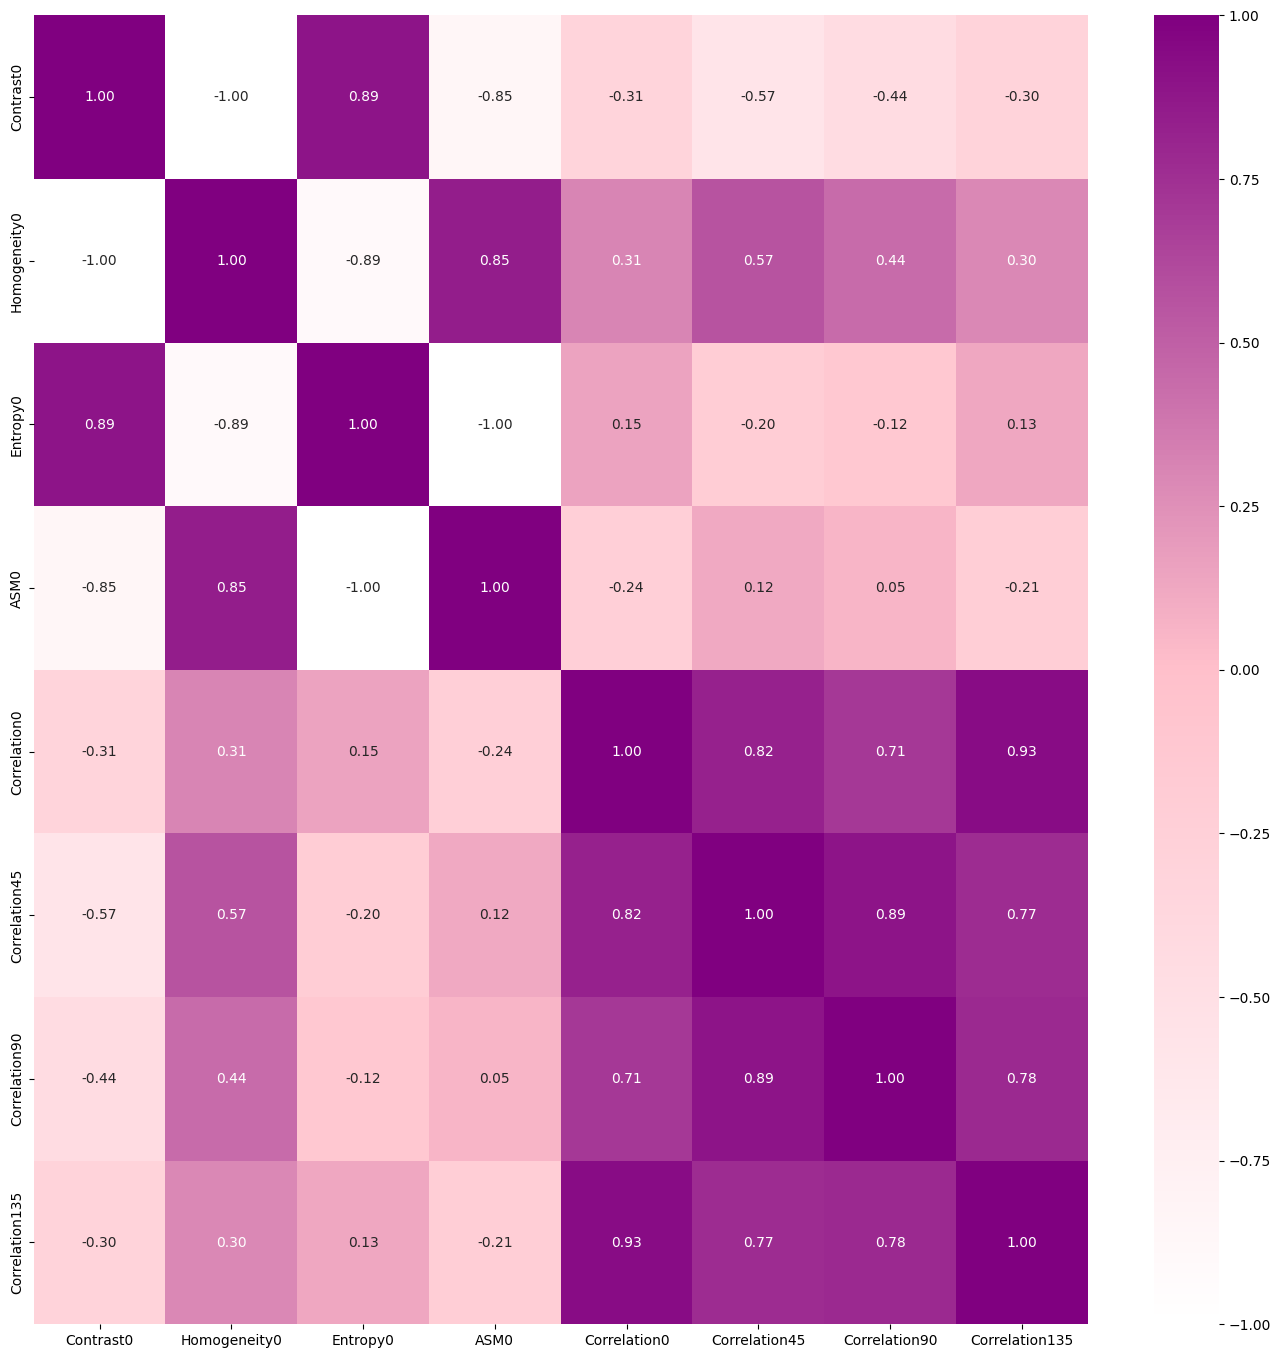

In [267]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [252]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 8)
(40, 8)


In [253]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [255]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [256]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.94      0.94      0.94        79
      Rosacea       0.94      0.94      0.94        81

     accuracy                           0.94       160
    macro avg       0.94      0.94      0.94       160
 weighted avg       0.94      0.94      0.94       160

[[74  5]
 [ 5 76]]
Accuracy: 0.9375

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.62      0.48      0.54        21
      Rosacea       0.54      0.68      0.60        19

     accuracy                           0.57        40
    macro avg       0.58      0.58      0.57        40
 weighted avg       0.59      0.57      0.57        40

[[10 11]
 [ 6 13]]
Accuracy: 0.575


In [257]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.67      0.48      0.56        79
      Rosacea       0.60      0.77      0.67        81

     accuracy                           0.62       160
    macro avg       0.63      0.62      0.62       160
 weighted avg       0.63      0.62      0.62       160

[[38 41]
 [19 62]]
Accuracy: 0.625

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.72      0.62      0.67        21
      Rosacea       0.64      0.74      0.68        19

     accuracy                           0.68        40
    macro avg       0.68      0.68      0.67        40
 weighted avg       0.68      0.68      0.67        40

[[13  8]
 [ 5 14]]
Accuracy: 0.675


In [258]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.71      0.67      0.69        79
      Rosacea       0.69      0.73      0.71        81

     accuracy                           0.70       160
    macro avg       0.70      0.70      0.70       160
 weighted avg       0.70      0.70      0.70       160

[[53 26]
 [22 59]]
Accuracy: 0.7

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.68      0.62      0.65        21
      Rosacea       0.62      0.68      0.65        19

     accuracy                           0.65        40
    macro avg       0.65      0.65      0.65        40
 weighted avg       0.65      0.65      0.65        40

[[13  8]
 [ 6 13]]
Accuracy: 0.65


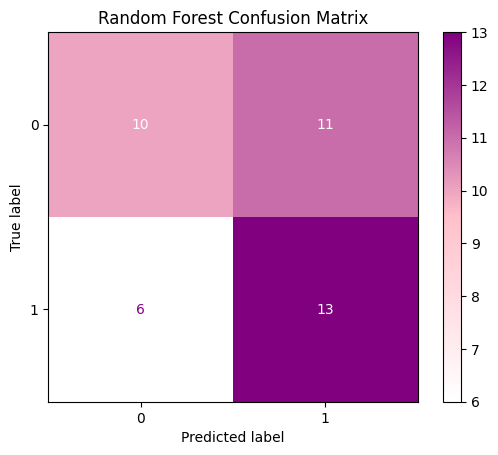

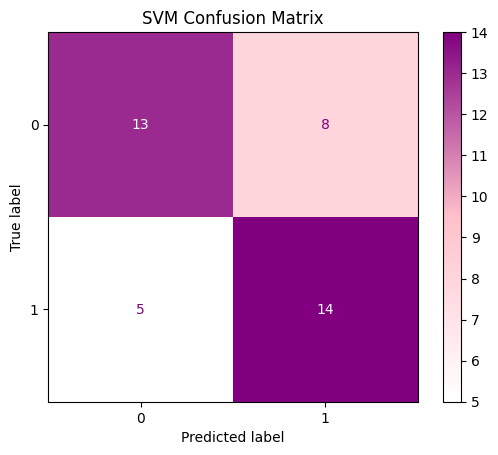

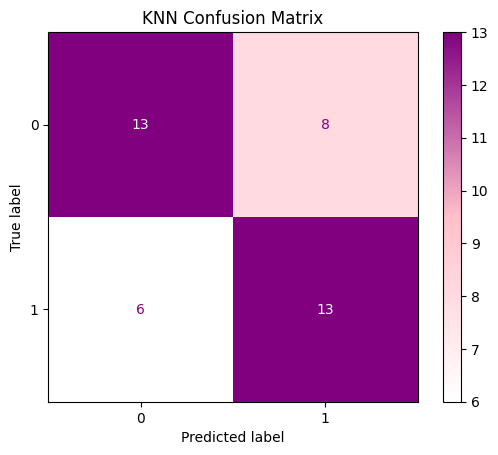

In [268]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")